# 기본

In [63]:
#모듈 호출

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as spst
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")  # matplotlib style 설정

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [64]:
#csv 파일 호출

df_orders=pd.read_csv("./data file/olist_orders.csv")
df_customers=pd.read_csv('./data file/olist_customers.csv')
df_order_items=pd.read_csv('./data file/olist_order_items.csv')
df_order_payments=pd.read_csv('./data file/olist_order_payments.csv')
df_products=pd.read_csv('./data file/olist_products.csv')
df_trans=pd.read_csv('./data file/product_category_name_translation.csv')

In [65]:
#전체 병합 파일 df 생성

df_co = pd.merge(df_customers, df_orders, on='customer_id', how='left')
df_co['total_orders'] = df_co.groupby('customer_unique_id')['order_id'].transform('count')
df_coi = pd.merge(df_co, df_order_items, on="order_id", how='left')
df_coi['total_order_items'] = df_coi.groupby('customer_unique_id')['customer_unique_id'].transform('count')
df_coip = pd.merge(df_coi, df_order_payments, on="order_id", how="left")
df_product=pd.merge(df_products,df_trans,on='product_category_name',how='outer')
mask = ~df_product['product_category_name_english'].isnull()
df_product.loc[mask, 'product_category_name'] = df_product.loc[mask, 'product_category_name_english']
df = pd.merge(df_coip, df_product, on="product_id", how="left")

# 1day / ndays 구분

In [66]:
#한 번 구매한 고객 df_1 생성
df_1 = df[df['total_orders']==1]

#한 번 구매한 고객 제외 df_n 생성
df_n = df[df['total_orders']!=1]

In [67]:
df_n['order_purchase_timestamp'] = pd.to_datetime(df_n['order_purchase_timestamp'])

# 데이터를 시간 순서대로 정렬
df_n = df_n.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 각 고객별로 주문 간 시간 간격을 계산하고 'duration_days' 열에 할당
df_n['duration_days'] = df_n.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# 첫 번째 주문의 'duration_days'를 NaN으로 처리
df_n.loc[df_n.groupby('customer_unique_id').cumcount() == 0, 'duration_days'] = pd.NaT
df_n['order_purchase_timestamp'] = pd.to_datetime(df_n['order_purchase_timestamp'])

# 데이터를 시간 순서대로 정렬
df_n = df_n.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 각 고객별로 주문 간 시간 간격을 계산하고 'duration_days' 열에 할당
df_n['duration_days'] = df_n.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# 첫 번째 주문의 'duration_days'를 NaN으로 처리
df_n.loc[df_n.groupby('customer_unique_id').cumcount() == 0, 'duration_days'] = pd.NaT


In [68]:
df_n.groupby('customer_unique_id').size()

customer_unique_id
00172711b30d52eea8b313a7f2cced02    2
004288347e5e88a27ded2bb23747066c    2
004b45ec5c64187465168251cd1c9c2f    2
0058f300f57d7b93c477a131a59b36c3    3
00a39521eb40f7012db50455bf083460    2
                                   ..
ff36be26206fffe1eb37afd54c70e18b    3
ff44401d0d8f5b9c54a47374eb48c1b8    4
ff8892f7c26aa0446da53d01b18df463    2
ff922bdd6bafcdf99cb90d7f39cea5b3    3
ffe254cc039740e17dd15a5305035928    2
Length: 2997, dtype: int64

# n_ndays / n_1day 구분

In [69]:
#Nan 값과 하루에 많이 주문한 고객 제외
df_duration=df_n[df_n['duration_days']!=0]
df_duration = df_duration.dropna(subset=['duration_days'])

df_n_ndays = df_duration.copy()

In [70]:
#단일 방문 n번 구매한 적이 있는 그룹 'df_n_1day': 1549명 -> 877명
df_n_1day=df_n[df_n['duration_days']<=0]
villain=list(set(df_duration['customer_unique_id']).intersection(set(df_n_1day['customer_unique_id'])))
df_n_1day=df_n_1day[~df_n_1day['customer_unique_id'].isin(villain)]

In [71]:
df_1.groupby('customer_unique_id').size()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Length: 93099, dtype: int64

---

---

# 이탈/잠재 만들기

In [72]:
df_n_1day.drop('duration_days',axis=1,inplace=True)

df_1day=pd.concat([df_1, df_n_1day])
df_1day

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,1.0,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,1.0,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,1.0,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,1.0,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15437,70a9b3a2a2f6c0e8cc4852bc3a591e2e,fed2005ccab4fcf1a40ebdaff032a148,13870,02b0bf9164ac7753f9880e46dba17f6c,delivered,2022-06-17 17:04:31,2022-06-17 17:15:21,2022-06-30 12:22:11,2022-07-07 00:00:00,2,...,1.0,credit_card,1.0,63.42,computers_accessories,75.0,17.0,6.0,58.0,computers_accessories
18460,5d0c6c3c37720178553332f2509b2568,ff44401d0d8f5b9c54a47374eb48c1b8,13070,c087855fe6f303205c09558f7f8103c8,delivered,2022-05-19 21:20:54,2022-05-19 21:35:16,2022-06-01 18:05:18,2022-06-12 00:00:00,2,...,2.0,voucher,1.0,28.47,fashion_bags_accessories,200.0,16.0,9.0,11.0,fashion_bags_accessories
105234,09c682ef897935e677a0996cfe2008f3,ff44401d0d8f5b9c54a47374eb48c1b8,13070,e28a4c66f1484567d1e42b3fab64d923,delivered,2022-05-19 21:20:54,2022-05-19 21:42:44,2022-05-31 17:06:38,2022-06-23 00:00:00,2,...,1.0,credit_card,1.0,0.72,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories
105235,09c682ef897935e677a0996cfe2008f3,ff44401d0d8f5b9c54a47374eb48c1b8,13070,e28a4c66f1484567d1e42b3fab64d923,delivered,2022-05-19 21:20:54,2022-05-19 21:42:44,2022-05-31 17:06:38,2022-06-23 00:00:00,2,...,2.0,voucher,1.0,38.28,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories


In [73]:
df_1day.groupby('customer_unique_id').size()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Length: 93976, dtype: int64

In [74]:
df_ndays=df_n_ndays

In [75]:
df_ndays.groupby('customer_unique_id').size()

customer_unique_id
00172711b30d52eea8b313a7f2cced02    1
004288347e5e88a27ded2bb23747066c    1
004b45ec5c64187465168251cd1c9c2f    1
0058f300f57d7b93c477a131a59b36c3    1
00a39521eb40f7012db50455bf083460    1
                                   ..
ff03923ad1eb9e32304deb7f9b2a45c9    1
ff22e30958c13ffe219db7d711e8f564    1
ff36be26206fffe1eb37afd54c70e18b    2
ff8892f7c26aa0446da53d01b18df463    1
ff922bdd6bafcdf99cb90d7f39cea5b3    2
Length: 2120, dtype: int64

In [76]:
from datetime import datetime

standard=datetime(2023, 8, 11, 0, 0, 0)

df_1day['order_purchase_timestamp'] = pd.to_datetime(df_1day['order_purchase_timestamp'])

#기준시보다 크거나 같으면 poten
df_poten=df_1day[df_1day['order_purchase_timestamp'] >= standard]

In [77]:
poten=list(set(df_poten['customer_unique_id']))
df_churn=df_1day[~df_1day['customer_unique_id'].isin(poten)]

# 데이터 정리

- df_1day: 하루에 구매한 고객 (우리가 전에 정한 Target)
- df_ndays: 여러번 반복 구매한 고객 (우리가 전에 정한 Sample)
- df_n_1day: 하루에 여러번 구매한 고객
- df_n_ndays: 여러날에 여러번 구매한 고객

- df_poten: 잠재고객(Target 중 돌아올 있는 가능성)
- df_churn: 이미 떠난 이탈 고객(Target 중 돌아올 X)

# 주소와 구매품목의 관계 검정

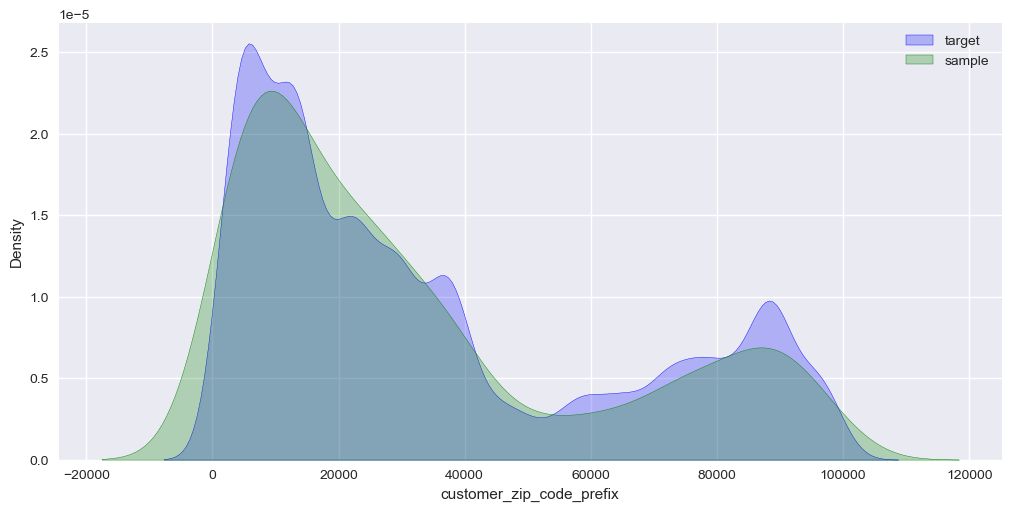

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# 각 데이터셋에 대한 kdeplot을 그립니다. 각각에 대해 label을 지정하여 범례에 나타나게 합니다.
sns.kdeplot(x='customer_zip_code_prefix', data=df_1day, fill=True, ax=ax, label='target', color='blue')
sns.kdeplot(x='customer_zip_code_prefix', data=df_ndays, fill=True, ax=ax, label='sample', color='green')

# 범례 표시
plt.legend()

plt.show()


<Axes: xlabel='customer_zip_code_prefix', ylabel='Count'>

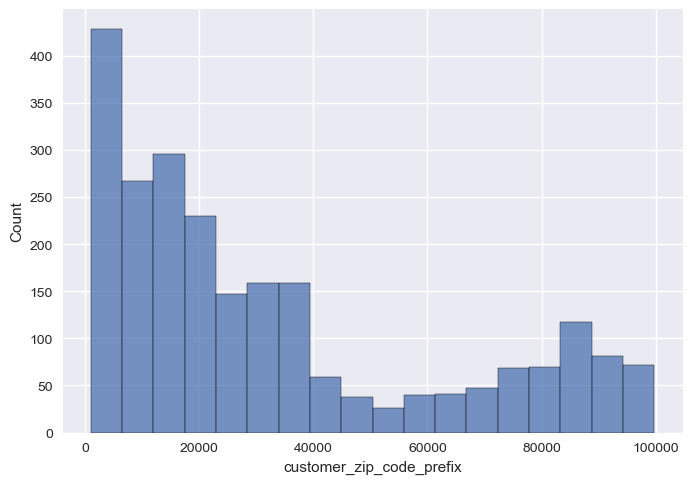

In [79]:
sns.histplot(data=df_ndays,x="customer_zip_code_prefix")
#sns.histplot(data=df_1day,x="customer_zip_code_prefix")

In [80]:
df_ndays['is_between_60000_100000'] = np.where((df_ndays['customer_zip_code_prefix'] >= 60000) & (df_ndays['customer_zip_code_prefix'] <= 100000), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,1.0,122.07,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,2.0,103.28,luggage_accessories,700.0,19.0,48.0,35.0,luggage_accessories,170.0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,1.0,49.85,furniture_decor,3450.0,23.0,35.0,35.0,furniture_decor,267.0,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,1.0,79.56,luggage_accessories,650.0,46.0,10.0,34.0,luggage_accessories,31.0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,1.0,26.78,electronics,175.0,22.0,12.0,15.0,electronics,10.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,1.0,92.76,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,1.0,92.76,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,6.0,66.74,bed_bath_table,350.0,25.0,9.0,19.0,bed_bath_table,186.0,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,2.0,57.60,bed_bath_table,1000.0,50.0,12.0,12.0,bed_bath_table,182.0,0


In [81]:
df_copy = df.copy()

In [82]:
df_copy['does_buy_sports_leisure'] = np.where((df_copy['product_category_name_english']=='sports_leisure'), 1, 0)
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,does_buy_sports_leisure
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,credit_card,6.0,88.78,books_general_interest,611.0,22.0,22.0,23.0,books_general_interest,0
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,credit_card,3.0,129.06,sports_leisure,1211.0,25.0,24.0,22.0,sports_leisure,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,credit_card,5.0,56.04,health_beauty,870.0,25.0,20.0,18.0,health_beauty,0
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,credit_card,2.0,711.07,watches_gifts,710.0,19.0,13.0,14.0,watches_gifts,0


In [83]:
df_ndays['does_buy_bed_bath'] = np.where((df_ndays['product_category_name_english']=='bed_bath_table'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000,does_buy_bed_bath
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,122.07,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,103.28,luggage_accessories,700.0,19.0,48.0,35.0,luggage_accessories,170.0,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,49.85,furniture_decor,3450.0,23.0,35.0,35.0,furniture_decor,267.0,0,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,79.56,luggage_accessories,650.0,46.0,10.0,34.0,luggage_accessories,31.0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,26.78,electronics,175.0,22.0,12.0,15.0,electronics,10.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,92.76,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,92.76,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,66.74,bed_bath_table,350.0,25.0,9.0,19.0,bed_bath_table,186.0,0,1
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,57.60,bed_bath_table,1000.0,50.0,12.0,12.0,bed_bath_table,182.0,0,1


In [84]:
df_ndays['does_buy_furniture_decor'] = np.where((df_ndays['product_category_name_english']=='furniture_decor'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000,does_buy_bed_bath,does_buy_furniture_decor
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,luggage_accessories,700.0,19.0,48.0,35.0,luggage_accessories,170.0,0,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,furniture_decor,3450.0,23.0,35.0,35.0,furniture_decor,267.0,0,0,1
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,luggage_accessories,650.0,46.0,10.0,34.0,luggage_accessories,31.0,0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,electronics,175.0,22.0,12.0,15.0,electronics,10.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,bed_bath_table,350.0,25.0,9.0,19.0,bed_bath_table,186.0,0,1,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,bed_bath_table,1000.0,50.0,12.0,12.0,bed_bath_table,182.0,0,1,0


In [85]:
df_ndays['is_between_60000_80000'] = np.where((df_ndays['customer_zip_code_prefix'] >= 60000) & (df_ndays['customer_zip_code_prefix'] <= 80000), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000,does_buy_bed_bath,does_buy_furniture_decor,is_between_60000_80000
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,NaN,NaN,NaN,NaN,NaN,16.0,0,0,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,700.0,19.0,48.0,35.0,luggage_accessories,170.0,0,0,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,3450.0,23.0,35.0,35.0,furniture_decor,267.0,0,0,1,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,650.0,46.0,10.0,34.0,luggage_accessories,31.0,0,0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,175.0,22.0,12.0,15.0,electronics,10.0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,22.0,0,0,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,3.0,0,0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,350.0,25.0,9.0,19.0,bed_bath_table,186.0,0,1,0,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,1000.0,50.0,12.0,12.0,bed_bath_table,182.0,0,1,0,0


In [86]:
df_ndays['does_buy_health_beauty'] = np.where((df_ndays['product_category_name_english']=='health_beauty'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000,does_buy_bed_bath,does_buy_furniture_decor,is_between_60000_80000,does_buy_health_beauty
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,NaN,NaN,NaN,NaN,16.0,0,0,0,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,19.0,48.0,35.0,luggage_accessories,170.0,0,0,0,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,23.0,35.0,35.0,furniture_decor,267.0,0,0,1,0,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,46.0,10.0,34.0,luggage_accessories,31.0,0,0,0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,22.0,12.0,15.0,electronics,10.0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,NaN,NaN,NaN,NaN,22.0,0,0,0,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,NaN,NaN,NaN,NaN,3.0,0,0,0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,25.0,9.0,19.0,bed_bath_table,186.0,0,1,0,0,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,50.0,12.0,12.0,bed_bath_table,182.0,0,1,0,0,0


In [87]:
df_ndays['is_between_70000_80000'] = np.where((df_ndays['customer_zip_code_prefix'] >= 70000) & (df_ndays['customer_zip_code_prefix'] <= 80000), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_60000_100000,does_buy_bed_bath,does_buy_furniture_decor,is_between_60000_80000,does_buy_health_beauty,is_between_70000_80000
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,NaN,NaN,NaN,16.0,0,0,0,0,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,48.0,35.0,luggage_accessories,170.0,0,0,0,0,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,35.0,35.0,furniture_decor,267.0,0,0,1,0,0,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,10.0,34.0,luggage_accessories,31.0,0,0,0,0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,12.0,15.0,electronics,10.0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,NaN,NaN,NaN,22.0,0,0,0,0,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,NaN,NaN,NaN,3.0,0,0,0,0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,9.0,19.0,bed_bath_table,186.0,0,1,0,0,0,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,12.0,12.0,bed_bath_table,182.0,0,1,0,0,0,0


In [88]:
df_copy['is_between_10000_30000'] = np.where((df_copy['customer_zip_code_prefix'] >= 10000) & (df_copy['customer_zip_code_prefix'] <= 30000), 1, 0)
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,does_buy_sports_leisure,is_between_10000_30000
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,0,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,0,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,6.0,88.78,books_general_interest,611.0,22.0,22.0,23.0,books_general_interest,0,0
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,3.0,129.06,sports_leisure,1211.0,25.0,24.0,22.0,sports_leisure,1,0
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,5.0,56.04,health_beauty,870.0,25.0,20.0,18.0,health_beauty,0,0
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,2.0,711.07,watches_gifts,710.0,19.0,13.0,14.0,watches_gifts,0,0


In [89]:
# 우선 교차표를 작성
table = pd.crosstab(df_copy['is_between_10000_30000'], df_copy['does_buy_sports_leisure'])
table

does_buy_sports_leisure,0,1
is_between_10000_30000,,
0,73344,6047
1,36145,2898


In [90]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=1.3851988137991218, pvalue=0.23921758134493987, dof=1, expected_freq=array([[73394.81229208,  5996.18770792],
       [36094.18770792,  2948.81229208]]))

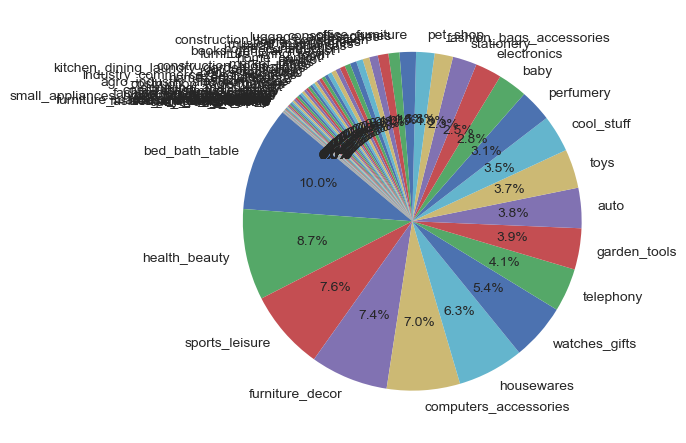

In [91]:
category_ratio= df_1day['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

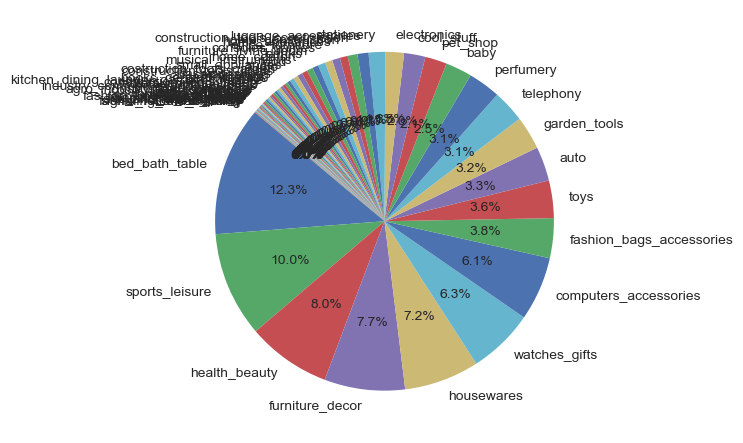

In [92]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

# sample 고객과 target 고객의 차이점은 구매 요일이다?

In [93]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek

In [94]:
df

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,4
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,credit_card,6.0,88.78,books_general_interest,611.0,22.0,22.0,23.0,books_general_interest,4
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,credit_card,3.0,129.06,sports_leisure,1211.0,25.0,24.0,22.0,sports_leisure,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,credit_card,5.0,56.04,health_beauty,870.0,25.0,20.0,18.0,health_beauty,5
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,credit_card,2.0,711.07,watches_gifts,710.0,19.0,13.0,14.0,watches_gifts,3


In [95]:
df_copy = df.copy()
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,4
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,credit_card,6.0,88.78,books_general_interest,611.0,22.0,22.0,23.0,books_general_interest,4
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,credit_card,3.0,129.06,sports_leisure,1211.0,25.0,24.0,22.0,sports_leisure,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,credit_card,5.0,56.04,health_beauty,870.0,25.0,20.0,18.0,health_beauty,5
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,credit_card,2.0,711.07,watches_gifts,710.0,19.0,13.0,14.0,watches_gifts,3


In [96]:
df_1day['order_purchase_timestamp'] = pd.to_datetime(df_1day['order_purchase_timestamp'])
df_1day['day_of_week'] = df_1day['order_purchase_timestamp'].dt.dayofweek

In [97]:
df_ndays['order_purchase_timestamp'] = pd.to_datetime(df_ndays['order_purchase_timestamp'])
df_ndays['day_of_week'] = df_ndays['order_purchase_timestamp'].dt.dayofweek

In [98]:
df_copy['is_wed'] = np.where((df_copy['day_of_week']==2), 1, 0)
df_copy.head(20)

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_wed
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,3,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,4,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,5,0
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2022-09-14 18:14:31,2022-09-14 18:25:11,2022-09-28 17:32:43,2022-10-04 00:00:00,2,...,1.0,282.21,sports_leisure,4450.0,60.0,15.0,15.0,sports_leisure,2,1
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,36e694cf4cbc2a4803200c35e84abdc4,delivered,2023-02-19 14:38:35,2023-02-19 14:50:37,2023-02-20 16:25:51,2023-03-05 00:00:00,1,...,1.0,22.77,computers_accessories,100.0,16.0,3.0,13.0,computers_accessories,6,0
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,1093c8304c7a003280dd34598194913d,delivered,2022-11-16 19:29:02,2022-11-16 19:55:41,2022-11-27 12:44:36,2022-12-08 00:00:00,1,...,3.0,36.01,NaN,250.0,15.0,8.0,20.0,NaN,2,1
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,1ebeea841c590e86a14a0d7a48e7d062,delivered,2023-01-18 12:35:44,2023-01-18 12:56:32,2023-01-26 15:17:57,2023-02-20 00:00:00,2,...,1.0,39.10,toys,350.0,28.0,10.0,12.0,toys,2,1
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,7433cbcc783205509d66a5260da5b574,delivered,2023-01-08 11:22:34,2023-01-08 11:35:27,2023-01-13 14:51:55,2023-02-05 00:00:00,1,...,1.0,122.47,furniture_decor,2500.0,40.0,10.0,30.0,furniture_decor,6,0


In [99]:
# df_ndays의 'customer_unique_id' 열의 고유 값들을 리스트로 추출
df_ndays_ids = df_ndays['customer_unique_id'].unique().tolist()

# df_copy의 'is_sample' 열을 생성, df_copy의 'customer_unique_id' 값이 df_ndays_ids 리스트에 있는지 여부에 따라 1 또는 0 할당
df_copy['is_sample'] = df_copy['customer_unique_id'].apply(lambda x: 1 if x in df_ndays_ids else 0)


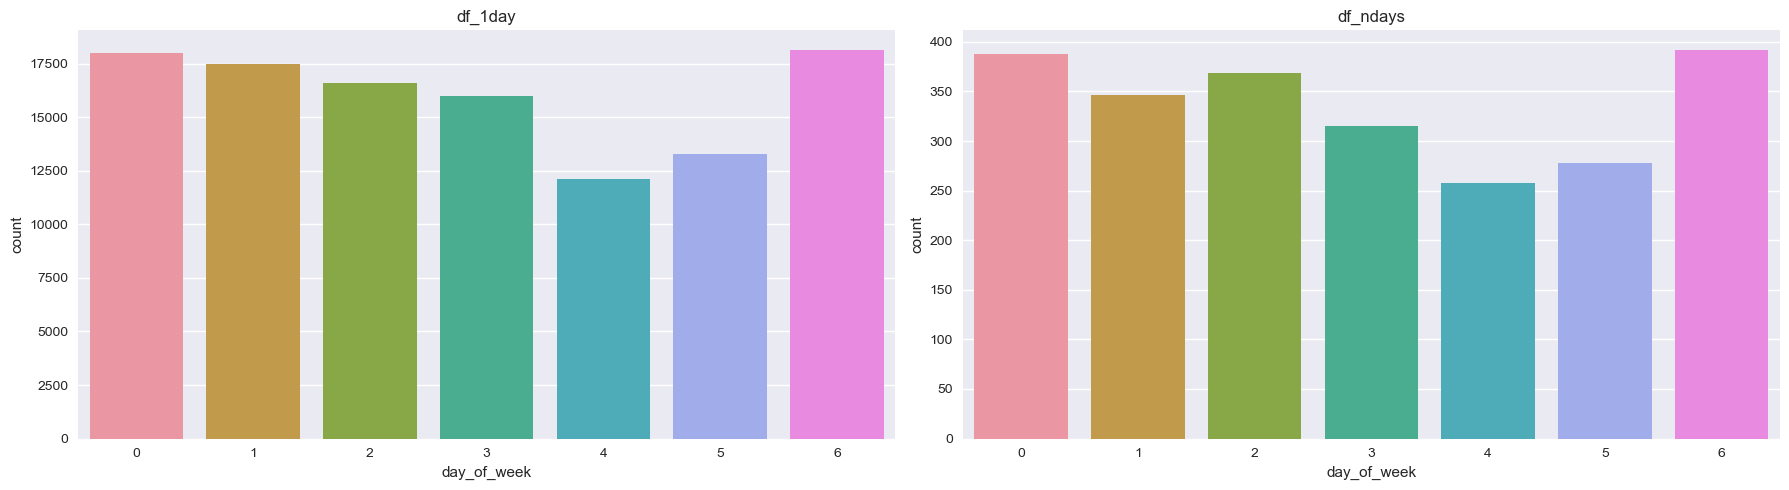

In [100]:
# 2개의 서브플롯을 만들기 위한 준비
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) # 1행 2열의 서브플롯 구성

# 첫 번째 서브플롯에 category에 대한 countplot 그리기
sns.countplot(x='day_of_week', data=df_1day, ax=axes[0])
axes[0].set_title('df_1day')

# 두 번째 서브플롯에 region에 대한 countplot 그리기
sns.countplot(x='day_of_week', data=df_ndays, ax=axes[1])
axes[1].set_title('df_ndays')

plt.tight_layout() # 서브플롯들 사이에 적절한 간격 유지
plt.show()

In [101]:
# 우선 교차표를 작성
table = pd.crosstab(df_copy['is_sample'], df_copy['is_wed'])
table

is_wed,0,1
is_sample,,
0,95781,16746
1,4928,979


In [102]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=12.489788595822326, pvalue=0.00040918249559097463, dof=1, expected_freq=array([[95686.0499772, 16840.9500228],
       [ 5022.9500228,   884.0499772]]))

In [103]:
df_ndays['is_wed'] = np.where((df_ndays['day_of_week']==2), 1, 0)

In [104]:
df_wed = df_ndays[df_ndays['is_wed']==1]
df_wed.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'total_orders', 'product_id',
       'seller_id', 'price', 'freight_value', 'total_order_items',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'duration_days',
       'is_between_60000_100000', 'does_buy_bed_bath',
       'does_buy_furniture_decor', 'is_between_60000_80000',
       'does_buy_health_beauty', 'is_between_70000_80000', 'day_of_week',
       'is_wed'],
      dtype='object')

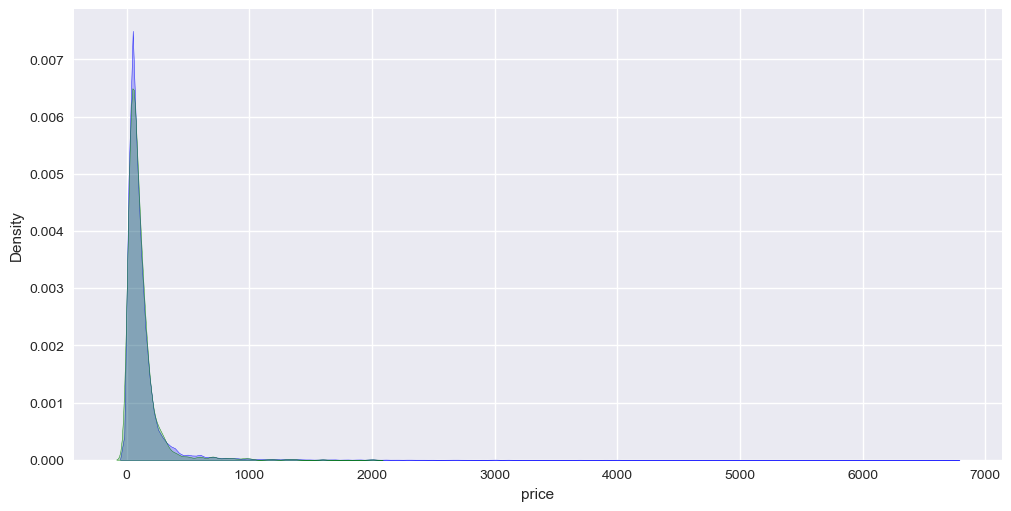

In [105]:
fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)
sns.kdeplot(x='price', data=df_1day, fill=True, ax=ax, label='target', color='blue')
sns.kdeplot(x='price', data=df_ndays, fill=True, ax=ax, label='sample', color='green')
plt.show()

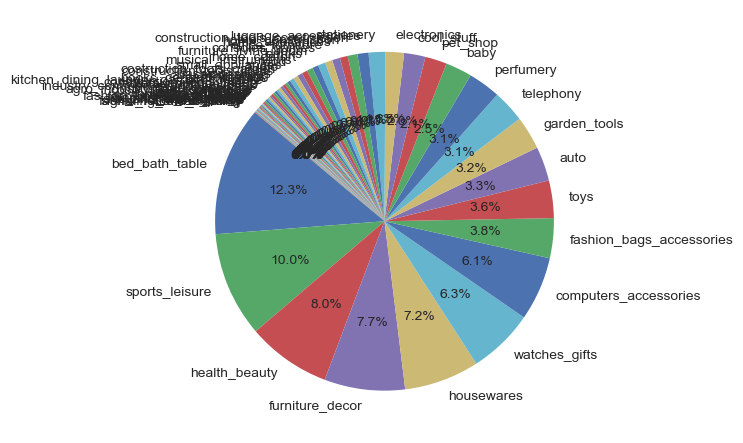

In [106]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

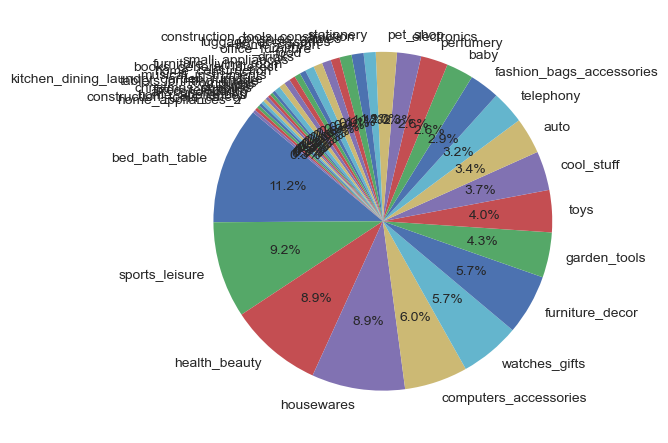

In [107]:
category_ratio= df_wed['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [108]:
df_ndays['did_buy_cool'] = np.where((df_ndays['product_category_name_english']=='cool_stuff'),1,0)

In [109]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['did_buy_cool'],df_ndays['is_wed'])
table

is_wed,0,1
did_buy_cool,,
0,1944,356
1,33,13


In [110]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=4.6367485843295455, pvalue=0.031294238998183885, dof=1, expected_freq=array([[1938.23529412,  361.76470588],
       [  38.76470588,    7.23529412]]))

# 구매 시간대와 재구매 여부 상관?

In [111]:
df_ndays['time_zone'] = df_ndays['order_purchase_timestamp'].dt.time
df_1day['time_zone'] = df_1day['order_purchase_timestamp'].dt.time
df_copy['time_zone'] = df_copy['order_purchase_timestamp'].dt.time

<Axes: xlabel='time_numeric', ylabel='Density'>

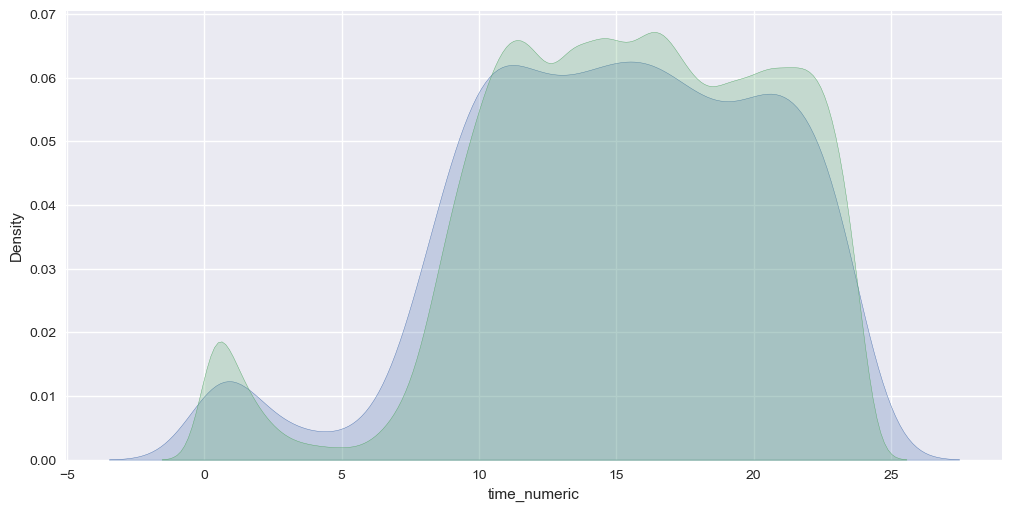

In [112]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
# 'time_zone' 열을 시간 단위의 소수로 변환하는 예
df_ndays['time_numeric'] = df_ndays['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_1day['time_numeric'] = df_1day['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_copy['time_numeric'] = df_copy['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# 이제 'time_numeric' 열을 사용하여 sns.kdeplot을 그립니다.
sns.kdeplot(x='time_numeric', data=df_ndays, fill=True, ax=ax)
sns.kdeplot(x='time_numeric', data=df_1day, fill=True, ax=ax)

In [113]:
df_ndays['is_between_2_10'] = np.where((df_ndays['time_numeric'] >= 2) & (df_ndays['time_numeric'] <= 10), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,does_buy_furniture_decor,is_between_60000_80000,does_buy_health_beauty,is_between_70000_80000,day_of_week,is_wed,did_buy_cool,time_zone,time_numeric,is_between_2_10
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,0,0,0,0,6,0,0,09:14:07,9.235278,1
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,0,0,0,0,5,0,0,07:36:54,7.615000,1
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,1,0,0,0,4,0,0,19:42:48,19.713333,0
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,0,0,0,0,2,1,0,18:09:41,18.161389,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,0,1,0,1,5,0,0,10:12:57,10.215833,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,0,0,0,0,6,0,0,09:03:23,9.056389,1
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,0,0,0,0,2,1,0,12:38:08,12.635556,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,0,0,0,0,5,0,0,23:25:43,23.428611,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,0,0,0,0,1,0,0,13:15:29,13.258056,0


In [114]:
df_2_10 = df_ndays[df_ndays['is_between_2_10']==1]

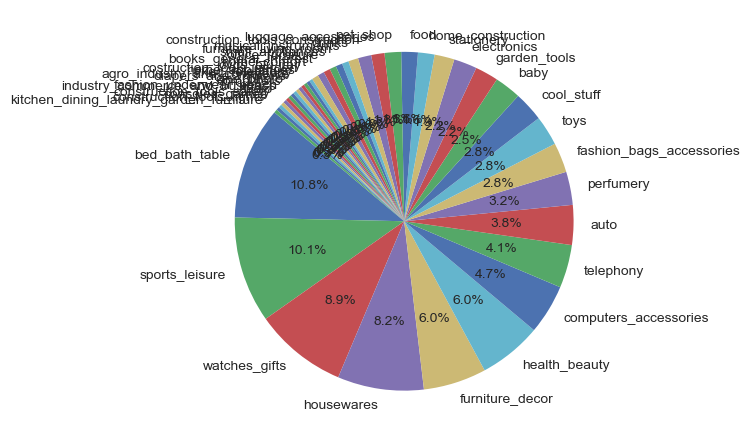

In [115]:
category_ratio= df_2_10['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

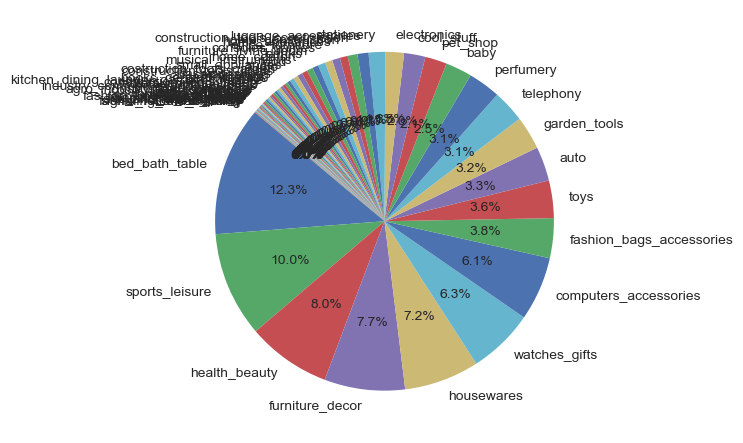

In [116]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [117]:
df_ndays['did_buy_watches_housewares_telephony'] = np.where(((df_ndays['product_category_name_english'] =='watches_gifts')|(df_ndays['product_category_name_english'] =='housewares')|((df_ndays['product_category_name_english'] =='telephony'))), 1, 0)

In [118]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['is_between_2_10'],df_ndays['did_buy_watches_housewares_telephony'])
table

did_buy_watches_housewares_telephony,0,1
is_between_2_10,,
0,1707,307
1,265,67


In [119]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=4.823089739285441, pvalue=0.028080965795820825, dof=1, expected_freq=array([[1692.92753623,  321.07246377],
       [ 279.07246377,   52.92753623]]))

# 결제 방식과 연관?

In [120]:
df_ndays.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'total_orders', 'product_id',
       'seller_id', 'price', 'freight_value', 'total_order_items',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'duration_days',
       'is_between_60000_100000', 'does_buy_bed_bath',
       'does_buy_furniture_decor', 'is_between_60000_80000',
       'does_buy_health_beauty', 'is_between_70000_80000', 'day_of_week',
       'is_wed', 'did_buy_cool', 'time_zone', 'time_numeric',
       'is_between_2_10', 'did_buy_watches_housewares_telephony'],
      dtype='object')

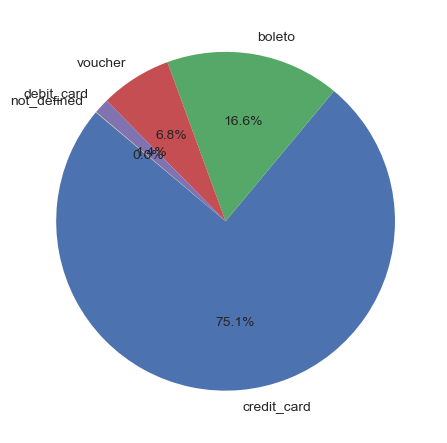

In [121]:
category_ratio= df_ndays['payment_type'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [123]:
df_copy['does_buy_sports_leisure'] = np.where((df_copy['product_category_name_english']=='sports_leisure'), 1, 0)
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_wed,is_sample,time_zone,time_numeric,does_buy_sports_leisure
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,54.0,64.0,31.0,office_furniture,0,0,0,15:05:35,15.093056,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,89.0,15.0,40.0,housewares,3,0,0,20:48:24,20.806667,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,52.0,52.0,17.0,office_furniture,4,0,0,16:07:45,16.129167,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,56.0,51.0,28.0,office_furniture,0,0,0,16:06:38,16.110556,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,45.0,15.0,35.0,home_confort,5,0,0,09:51:30,9.858333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,22.0,22.0,23.0,books_general_interest,4,0,0,15:48:17,15.804722,0
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,25.0,24.0,22.0,sports_leisure,1,0,0,08:20:22,8.339444,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,25.0,20.0,18.0,health_beauty,5,0,0,20:11:50,20.197222,0
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,19.0,13.0,14.0,watches_gifts,3,0,0,21:08:33,21.142500,0


In [126]:
df_2_10 = df_ndays[df_ndays['is_between_2_10']==1]

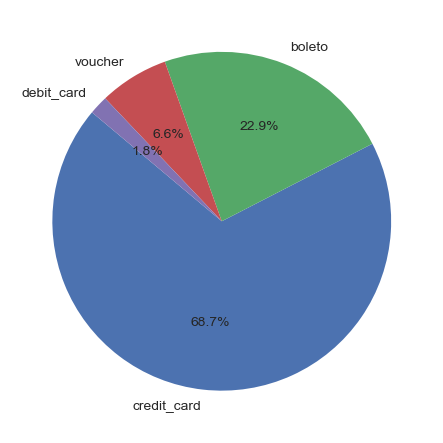

In [127]:
category_ratio= df_2_10['payment_type'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

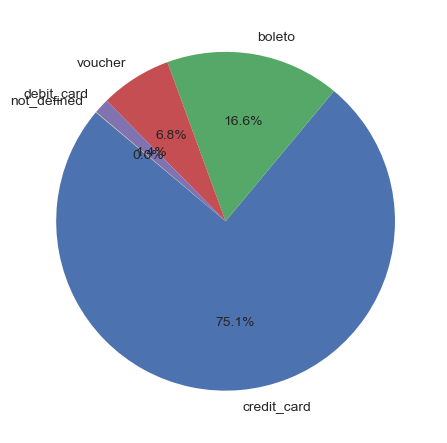

In [128]:
category_ratio= df_ndays['payment_type'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [129]:
df_ndays['is_boleto'] = np.where((df_ndays['payment_type']=='boleto'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,does_buy_health_beauty,is_between_70000_80000,day_of_week,is_wed,did_buy_cool,time_zone,time_numeric,is_between_2_10,did_buy_watches_housewares_telephony,is_boleto
42536,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,c306eca42d32507b970739b5b6a5a33a,canceled,2023-08-13 09:14:07,NaN,NaN,2023-09-05 00:00:00,2,...,0,0,6,0,0,09:14:07,9.235278,1,0,0
26360,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,08204559bebd39e09ee52dcb56d8faa2,delivered,2023-01-14 07:36:54,2023-01-14 07:49:28,2023-01-19 22:14:14,2023-02-09 00:00:00,2,...,0,0,5,0,0,07:36:54,7.615000,1,0,0
103725,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,9392c5e72885ad5aba87e6223ca9838d,delivered,2023-05-26 19:42:48,2023-05-29 03:31:20,2023-06-19 17:05:23,2023-07-11 00:00:00,2,...,0,0,4,0,0,19:42:48,19.713333,0,0,1
43303,8ac44e9c15d396b8c3c7cbab0fff4536,0058f300f57d7b93c477a131a59b36c3,41370,81a93b2fa39e104b865b2bc471c16008,delivered,2023-03-22 18:09:41,2023-03-22 18:27:58,2023-04-04 23:05:57,2023-04-16 00:00:00,2,...,0,0,2,1,0,18:09:41,18.161389,0,0,0
104215,cbb68c721ba9ddb30d8a490cc1897fa1,00a39521eb40f7012db50455bf083460,72595,cea3e6c11eb60acb9d8d4d51694832f8,delivered,2023-06-03 10:12:57,2023-06-03 10:50:00,2023-06-19 16:04:46,2023-07-11 00:00:00,2,...,0,1,5,0,0,10:12:57,10.215833,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117377,75c6e03e7206bd1dd59f427c9f75142a,ff36be26206fffe1eb37afd54c70e18b,13057,81b7c7bbc8ec003eeb67d87441a6a148,canceled,2023-08-20 09:03:23,NaN,NaN,2023-09-03 00:00:00,3,...,0,0,6,0,0,09:03:23,9.056389,1,0,0
31740,3483b2a9e678865616e7d1b69b28dd4c,ff36be26206fffe1eb37afd54c70e18b,13057,47282cfe5747c1c19920f090e491d285,canceled,2023-08-23 12:38:08,NaN,NaN,2023-09-06 00:00:00,3,...,0,0,2,1,0,12:38:08,12.635556,0,0,0
35359,e53e1eedc9ebf9fa7a3318c60ece1d25,ff8892f7c26aa0446da53d01b18df463,45972,1c308eca3f339414a92e518e2a2e5ee9,delivered,2022-11-26 23:25:43,2022-11-26 23:34:29,2023-01-23 14:37:27,2022-12-29 00:00:00,2,...,0,0,5,0,0,23:25:43,23.428611,0,0,0
95172,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,5f79e2da24a52e76bc22897df03a7901,delivered,2022-08-23 13:15:29,2022-08-23 13:30:19,2022-09-25 21:34:47,2022-09-21 00:00:00,3,...,0,0,1,0,0,13:15:29,13.258056,0,0,0


In [130]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['is_between_2_10'],df_ndays['is_boleto'])
table

is_boleto,0,1
is_between_2_10,,
0,1700,314
1,256,76


In [131]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=10.439872657863841, pvalue=0.0012332377235012824, dof=1, expected_freq=array([[1679.19181586,  334.80818414],
       [ 276.80818414,   55.19181586]]))

# 잠재고객 파악

In [132]:
df_poten

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
16,a7c125a0a07b75146167b7f04a7f8e98,5c2991dbd08bbf3cf410713c4de5a0b5,22750,72bab69c50432c6f94d8b50a5f84b69a,delivered,2023-08-13 23:45:05,2023-08-13 23:55:13,2023-08-17 20:03:08,2023-08-30 00:00:00,1,...,1.0,credit_card,2.0,136.93,auto,1200.0,16.0,9.0,31.0,auto
92,6c9a5923526346cbc0bd7bbd92269c01,cf6d4152d758efc43910e0141ae5b912,3733,580e2b6c3cb7687af1cb01ebeed86265,delivered,2023-08-22 11:39:32,2023-08-22 11:50:14,2023-08-23 18:34:25,2023-08-27 00:00:00,1,...,1.0,credit_card,8.0,361.20,watches_gifts,250.0,16.0,16.0,16.0,watches_gifts
93,1b2cb35b19b40b61f953d32ea157b337,468d559ef2dcd2bea6d8db78959fb90f,83709,fba547ee0dbc8830f00e8d3cc83bf246,delivered,2023-08-25 11:24:27,2023-08-25 11:35:18,2023-08-30 19:54:25,2023-09-19 00:00:00,1,...,1.0,credit_card,1.0,39.15,computers_accessories,150.0,31.0,3.0,28.0,computers_accessories
118,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,38289de96763d9d81470f67583f4b2f0,delivered,2023-08-22 11:49:11,2023-08-23 02:44:21,2023-08-29 19:48:37,2023-08-27 00:00:00,1,...,1.0,boleto,1.0,76.15,health_beauty,350.0,19.0,12.0,13.0,health_beauty
169,2f97782bbc64b71cba9e79d12757479b,7aeb8dc11cd50c32f37fea0435c4e9b1,5874,ac1a1d01dcd4350d31887f6eab3f63d5,delivered,2023-08-23 21:43:41,2023-08-23 21:55:16,2023-08-30 21:05:56,2023-08-31 00:00:00,1,...,1.0,debit_card,1.0,35.65,small_appliances_home_oven_and_coffee,150.0,27.0,13.0,17.0,small_appliances_home_oven_and_coffee
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80314,7fe022a904d647429c6e08a8f34c9b22,931a4a1a3e2cf8b4b4d33922f1469dbe,12243,1c3f752b9a4d09bf1e016439a427d5f8,delivered,2023-08-17 23:21:15,2023-08-17 23:35:14,2023-08-21 19:36:43,2023-08-23 00:00:00,2,...,1.0,debit_card,1.0,23.88,arts_and_craftmanship,100.0,22.0,2.0,15.0,arts_and_craftmanship
12873,dc6ab71bcbf17b38e8702924f379b68a,b5d391e8447d5ae0f8b852be83249e07,18120,ba75e370e47503142da34eea6301546a,delivered,2023-08-14 20:14:55,2023-08-14 20:25:26,2023-08-24 17:08:30,2023-08-30 00:00:00,2,...,1.0,credit_card,8.0,379.32,construction_tools_lights,3750.0,50.0,50.0,50.0,construction_tools_lights
65270,939b596a4a7229ebad09bcbad40538e6,b948343ff2e4e183e27e22ca63968d2b,5848,f22994b30f7ab7b86eacb2ea99e61a86,delivered,2023-08-16 10:30:31,2023-08-18 02:35:17,2023-08-21 17:27:56,2023-08-21 00:00:00,2,...,1.0,boleto,1.0,88.62,sports_leisure,400.0,16.0,9.0,11.0,sports_leisure
20994,c9b91aae07c6cd838cac23a7e534e1df,d649357bd5b1b116bf9662f41259db37,14300,3058f418c175f89b5dc680bcb5634ab1,delivered,2023-08-22 18:03:39,2023-08-22 18:15:39,2023-08-28 09:52:09,2023-09-14 00:00:00,2,...,1.0,credit_card,4.0,92.03,fashion_bags_accessories,500.0,16.0,16.0,16.0,fashion_bags_accessories


In [133]:
df_poten['time_zone'] = df_poten['order_purchase_timestamp'].dt.time
df_poten['time_numeric'] = df_poten['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_poten

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,time_zone,time_numeric
16,a7c125a0a07b75146167b7f04a7f8e98,5c2991dbd08bbf3cf410713c4de5a0b5,22750,72bab69c50432c6f94d8b50a5f84b69a,delivered,2023-08-13 23:45:05,2023-08-13 23:55:13,2023-08-17 20:03:08,2023-08-30 00:00:00,1,...,2.0,136.93,auto,1200.0,16.0,9.0,31.0,auto,23:45:05,23.751389
92,6c9a5923526346cbc0bd7bbd92269c01,cf6d4152d758efc43910e0141ae5b912,3733,580e2b6c3cb7687af1cb01ebeed86265,delivered,2023-08-22 11:39:32,2023-08-22 11:50:14,2023-08-23 18:34:25,2023-08-27 00:00:00,1,...,8.0,361.20,watches_gifts,250.0,16.0,16.0,16.0,watches_gifts,11:39:32,11.658889
93,1b2cb35b19b40b61f953d32ea157b337,468d559ef2dcd2bea6d8db78959fb90f,83709,fba547ee0dbc8830f00e8d3cc83bf246,delivered,2023-08-25 11:24:27,2023-08-25 11:35:18,2023-08-30 19:54:25,2023-09-19 00:00:00,1,...,1.0,39.15,computers_accessories,150.0,31.0,3.0,28.0,computers_accessories,11:24:27,11.407500
118,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,38289de96763d9d81470f67583f4b2f0,delivered,2023-08-22 11:49:11,2023-08-23 02:44:21,2023-08-29 19:48:37,2023-08-27 00:00:00,1,...,1.0,76.15,health_beauty,350.0,19.0,12.0,13.0,health_beauty,11:49:11,11.819722
169,2f97782bbc64b71cba9e79d12757479b,7aeb8dc11cd50c32f37fea0435c4e9b1,5874,ac1a1d01dcd4350d31887f6eab3f63d5,delivered,2023-08-23 21:43:41,2023-08-23 21:55:16,2023-08-30 21:05:56,2023-08-31 00:00:00,1,...,1.0,35.65,small_appliances_home_oven_and_coffee,150.0,27.0,13.0,17.0,small_appliances_home_oven_and_coffee,21:43:41,21.728056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80314,7fe022a904d647429c6e08a8f34c9b22,931a4a1a3e2cf8b4b4d33922f1469dbe,12243,1c3f752b9a4d09bf1e016439a427d5f8,delivered,2023-08-17 23:21:15,2023-08-17 23:35:14,2023-08-21 19:36:43,2023-08-23 00:00:00,2,...,1.0,23.88,arts_and_craftmanship,100.0,22.0,2.0,15.0,arts_and_craftmanship,23:21:15,23.354167
12873,dc6ab71bcbf17b38e8702924f379b68a,b5d391e8447d5ae0f8b852be83249e07,18120,ba75e370e47503142da34eea6301546a,delivered,2023-08-14 20:14:55,2023-08-14 20:25:26,2023-08-24 17:08:30,2023-08-30 00:00:00,2,...,8.0,379.32,construction_tools_lights,3750.0,50.0,50.0,50.0,construction_tools_lights,20:14:55,20.248611
65270,939b596a4a7229ebad09bcbad40538e6,b948343ff2e4e183e27e22ca63968d2b,5848,f22994b30f7ab7b86eacb2ea99e61a86,delivered,2023-08-16 10:30:31,2023-08-18 02:35:17,2023-08-21 17:27:56,2023-08-21 00:00:00,2,...,1.0,88.62,sports_leisure,400.0,16.0,9.0,11.0,sports_leisure,10:30:31,10.508611
20994,c9b91aae07c6cd838cac23a7e534e1df,d649357bd5b1b116bf9662f41259db37,14300,3058f418c175f89b5dc680bcb5634ab1,delivered,2023-08-22 18:03:39,2023-08-22 18:15:39,2023-08-28 09:52:09,2023-09-14 00:00:00,2,...,4.0,92.03,fashion_bags_accessories,500.0,16.0,16.0,16.0,fashion_bags_accessories,18:03:39,18.060833


In [141]:
df_1day['is_poten'] = np.where(df_1day['order_purchase_timestamp'] >= standard, 1, 0)

<Axes: xlabel='time_numeric', ylabel='Density'>

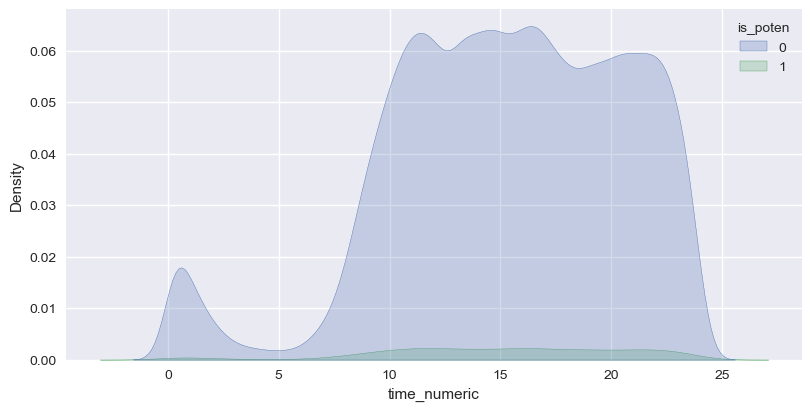

In [143]:
fig, ax = plt.subplots(figsize=(8,4),constrained_layout=True)
# 'time_zone' 열을 시간 단위의 소수로 변환하는 예
df_poten['time_numeric'] = df_poten['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_1day['time_numeric'] = df_1day['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# 이제 'time_numeric' 열을 사용하여 sns.kdeplot을 그립니다.
sns.kdeplot(x='time_numeric', data=df_1day, fill=True, ax=ax, hue = 'is_poten')

In [144]:
df_1day.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'total_orders', 'product_id',
       'seller_id', 'price', 'freight_value', 'total_order_items',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'day_of_week', 'time_zone',
       'time_numeric', 'is_poten'],
      dtype='object')

In [146]:
df_poten['is_between_2_10'] = np.where((df_poten['time_numeric'] >= 2) & (df_poten['time_numeric'] <= 10), 1, 0)

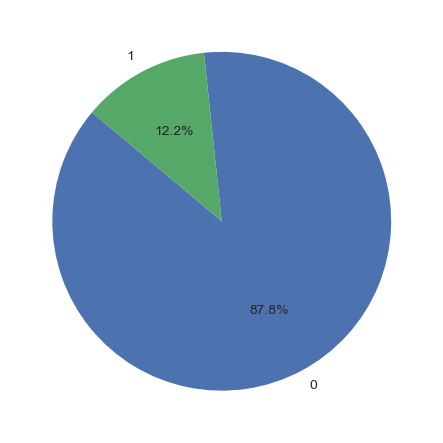

In [148]:
category_ratio= df_poten['is_between_2_10'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [149]:
df_poten['order_purchase_timestamp'] = pd.to_datetime(df_poten['order_purchase_timestamp'])
df_poten['day_of_week'] = df_poten['order_purchase_timestamp'].dt.dayofweek

In [150]:
df_poten['is_wed'] = np.where((df_poten['day_of_week'] ==2 ), 1, 0)

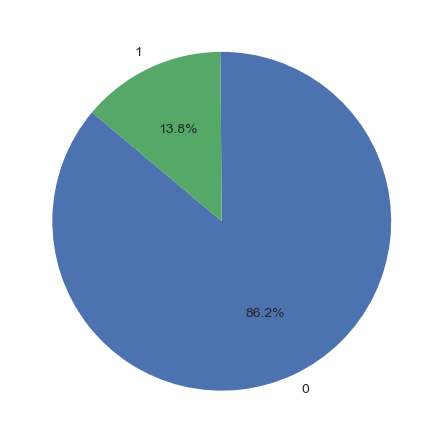

In [151]:
category_ratio= df_poten['is_wed'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [152]:
df_poten['is_between_10000_30000'] = np.where((df_poten['customer_zip_code_prefix'] >= 10000) & (df_poten['customer_zip_code_prefix'] <= 30000), 1, 0)
df_poten

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,time_zone,time_numeric,is_between_2_10,day_of_week,is_wed,is_between_10000_30000
16,a7c125a0a07b75146167b7f04a7f8e98,5c2991dbd08bbf3cf410713c4de5a0b5,22750,72bab69c50432c6f94d8b50a5f84b69a,delivered,2023-08-13 23:45:05,2023-08-13 23:55:13,2023-08-17 20:03:08,2023-08-30 00:00:00,1,...,16.0,9.0,31.0,auto,23:45:05,23.751389,0,6,0,1
92,6c9a5923526346cbc0bd7bbd92269c01,cf6d4152d758efc43910e0141ae5b912,3733,580e2b6c3cb7687af1cb01ebeed86265,delivered,2023-08-22 11:39:32,2023-08-22 11:50:14,2023-08-23 18:34:25,2023-08-27 00:00:00,1,...,16.0,16.0,16.0,watches_gifts,11:39:32,11.658889,0,1,0,0
93,1b2cb35b19b40b61f953d32ea157b337,468d559ef2dcd2bea6d8db78959fb90f,83709,fba547ee0dbc8830f00e8d3cc83bf246,delivered,2023-08-25 11:24:27,2023-08-25 11:35:18,2023-08-30 19:54:25,2023-09-19 00:00:00,1,...,31.0,3.0,28.0,computers_accessories,11:24:27,11.407500,0,4,0,0
118,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,38289de96763d9d81470f67583f4b2f0,delivered,2023-08-22 11:49:11,2023-08-23 02:44:21,2023-08-29 19:48:37,2023-08-27 00:00:00,1,...,19.0,12.0,13.0,health_beauty,11:49:11,11.819722,0,1,0,0
169,2f97782bbc64b71cba9e79d12757479b,7aeb8dc11cd50c32f37fea0435c4e9b1,5874,ac1a1d01dcd4350d31887f6eab3f63d5,delivered,2023-08-23 21:43:41,2023-08-23 21:55:16,2023-08-30 21:05:56,2023-08-31 00:00:00,1,...,27.0,13.0,17.0,small_appliances_home_oven_and_coffee,21:43:41,21.728056,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80314,7fe022a904d647429c6e08a8f34c9b22,931a4a1a3e2cf8b4b4d33922f1469dbe,12243,1c3f752b9a4d09bf1e016439a427d5f8,delivered,2023-08-17 23:21:15,2023-08-17 23:35:14,2023-08-21 19:36:43,2023-08-23 00:00:00,2,...,22.0,2.0,15.0,arts_and_craftmanship,23:21:15,23.354167,0,3,0,1
12873,dc6ab71bcbf17b38e8702924f379b68a,b5d391e8447d5ae0f8b852be83249e07,18120,ba75e370e47503142da34eea6301546a,delivered,2023-08-14 20:14:55,2023-08-14 20:25:26,2023-08-24 17:08:30,2023-08-30 00:00:00,2,...,50.0,50.0,50.0,construction_tools_lights,20:14:55,20.248611,0,0,0,1
65270,939b596a4a7229ebad09bcbad40538e6,b948343ff2e4e183e27e22ca63968d2b,5848,f22994b30f7ab7b86eacb2ea99e61a86,delivered,2023-08-16 10:30:31,2023-08-18 02:35:17,2023-08-21 17:27:56,2023-08-21 00:00:00,2,...,16.0,9.0,11.0,sports_leisure,10:30:31,10.508611,0,2,1,0
20994,c9b91aae07c6cd838cac23a7e534e1df,d649357bd5b1b116bf9662f41259db37,14300,3058f418c175f89b5dc680bcb5634ab1,delivered,2023-08-22 18:03:39,2023-08-22 18:15:39,2023-08-28 09:52:09,2023-09-14 00:00:00,2,...,16.0,16.0,16.0,fashion_bags_accessories,18:03:39,18.060833,0,1,0,1


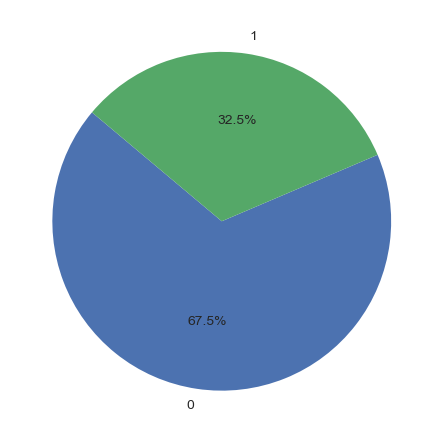

In [153]:
category_ratio= df_poten['is_between_10000_30000'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()